In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


## Exploring the dataset :

In [5]:
medium_articles = pd.read_csv("./articles.csv")
medium_articles.head()

,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


Total Number of unique authors : 182


C:\Users\Yuvraj Pardeshi\miniconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Yuvraj Pardeshi\miniconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


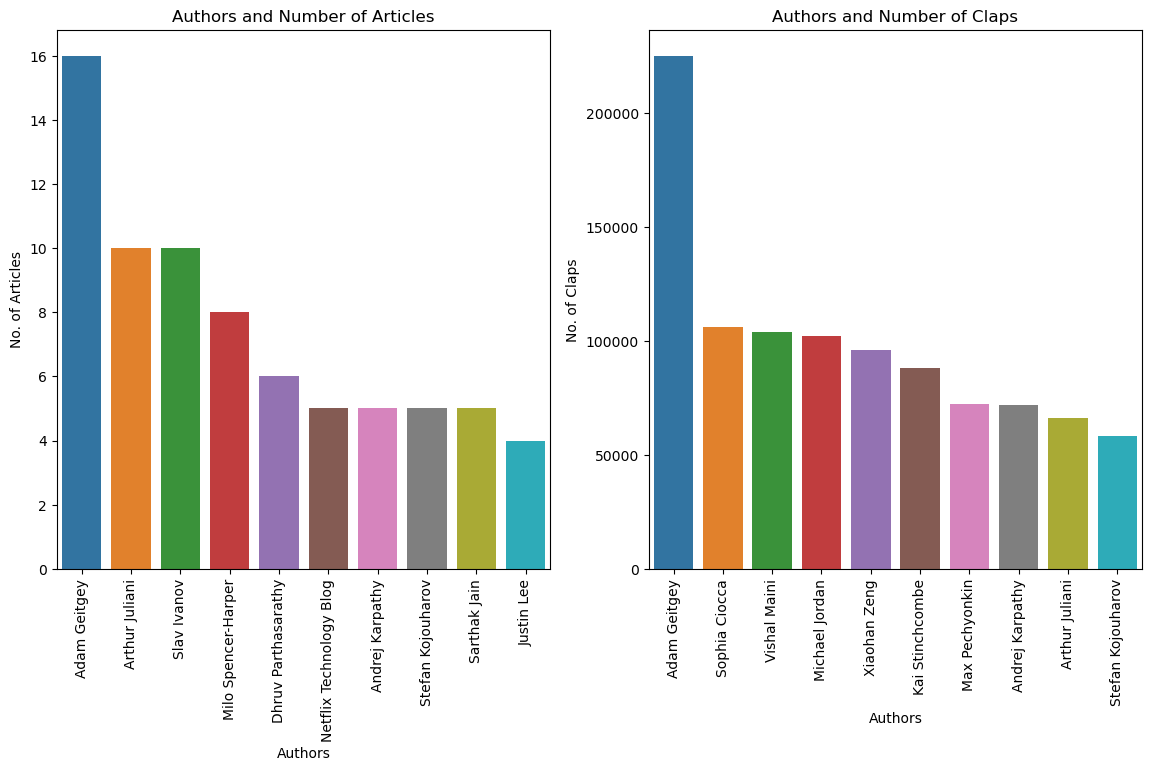

In [6]:
article_text = medium_articles.text
# visualise first article print few words from it
#print("First 1000 words in first article are : \n",article_text[0][:1000])

#total number of author
print(f"Total Number of unique authors : {len(medium_articles.author.unique())}")

#counting the articles of different authors
article_counts = dict()
for author in medium_articles.author:
    article_count = len(medium_articles[medium_articles["author"]==author])
    article_counts[author] = article_count

#sorting the article_counts on the basis of article count
article_counts = dict(sorted(article_counts.items(), key=lambda x: x[1], reverse=True))


#plot histogram of top 10 authors and their article counts
plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
sns.barplot(x = list(article_counts.keys())[:10],y=list(article_counts.values())[:10])
plt.title("Authors and Number of Articles")
plt.xlabel("Authors")
plt.ylabel("No. of Articles")
plt.xticks(rotation = 90) 



#counting the total number of claps for each author
def convert_to_num(clap_count):
    if "K" in clap_count:
        if "." in clap_count:
            clap_count = re.sub("\.","",clap_count[:-1])+"00"
        else:
            clap_count = clap_count[:-1]+"000"
    return(int(clap_count))

medium_articles.claps = medium_articles.claps.apply(convert_to_num)

#couting total number of claps for each author
clap_counts = dict()
for author in medium_articles.author:
    clap_count = medium_articles[medium_articles["author"]==author]["claps"]
    clap_counts[author] = sum(clap_count)

#sort clap_counts on the basis of counting of claps
clap_counts = dict(sorted(clap_counts.items(), key=lambda x: x[1], reverse=True))

#plot histogram of top 10 authors and their article counts
plt.subplot(1, 2, 2)
sns.barplot(x = list(clap_counts.keys())[:10],y=list(clap_counts.values())[:10])
plt.title("Authors and Number of Claps")
plt.xlabel("Authors")
plt.ylabel("No. of Claps")
plt.xticks(rotation = 90) 
plt.show()

## Preprocessing Text Data

In [7]:
#lowercase the articles 
medium_articles.text = medium_articles.text.apply(lambda t : t.lower())

In [8]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the text data
medium_articles.text = medium_articles.text.apply(lambda x:expand_contractions(x))

**Removing Stopwords and Puctuations**: Stopwords are the words that are highly occurred in a language; they do not add any significance to the sentence. "a," "an," "the," "in" are some examples of stopwords. So we generally ignore stop words during our NLP task. In some NLP tasks, stop words are also important, but stopwords are unnecessary for topic modeling. We also remove punctuation marks because they are also unnecessary and do not contribute anything.

In [99]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [10]:
print(f"These are the pucntions which string.punctuation consist :  {string.punctuation}")

These are the pucntions which string.punctuation consist :  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [11]:
stop_words = set(stopwords.words('english')) 

def remove_stopwords(article):
    "Return the articel after remvoing stopwords"
    article_tokens = word_tokenize(article) 
    filtered_article = [word for word in article_tokens if not word in stop_words] 
    return " ".join(filtered_article)


#removing stopwords
medium_articles.text = medium_articles.text.apply(remove_stopwords)

#removing Punctuations 
medium_articles.text = medium_articles.text.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

#removing digits
medium_articles.text = medium_articles.text.apply(lambda x: re.sub('\w*\d\w*','', x))

medium_articles.text[50]

'upd  april      scikit flow merged tensorflow since version  called tensorflow learn tflearn  google released machine learning framework called tensorflow ’ taking world storm   stars github  lot publicity general excitement ai researchers   use something regular problem data scientist may   ai researcher — build interesting problems time   reasonable question  data scientist  already number tools toolbox  r  scikit learn  etc   care yet another framework  answer two part  let ’ start simple example — take titanic dataset kaggle  first  make sure installed tensorflow scikit learn helpful libs  including scikit flow simplifying lot work tensorflow  get dataset code http  githubcomilblackdragontfexamples quick look data  use ipython ipython notebook ease interactive exploration   let ’ test predict survived class  based float variables scikit learn  separate dataset features target  fill na data zeros build logistic regression  predicting training data gives us measure accuracy  cause ’

In [12]:
def remove_extra_marks(article):
    extra_keys = ["’","—","”","“"]
    article_tokens = word_tokenize(article) 
    filtered_article = [word for word in article_tokens if not word in extra_keys] 
    return " ".join(filtered_article)
    
medium_articles.text = medium_articles.text.apply(remove_extra_marks)

In [13]:
medium_articles.text[50]

'upd april scikit flow merged tensorflow since version called tensorflow learn tflearn google released machine learning framework called tensorflow taking world storm stars github lot publicity general excitement ai researchers use something regular problem data scientist may ai researcher build interesting problems time reasonable question data scientist already number tools toolbox r scikit learn etc care yet another framework answer two part let start simple example take titanic dataset kaggle first make sure installed tensorflow scikit learn helpful libs including scikit flow simplifying lot work tensorflow get dataset code http githubcomilblackdragontfexamples quick look data use ipython ipython notebook ease interactive exploration let test predict survived class based float variables scikit learn separate dataset features target fill na data zeros build logistic regression predicting training data gives us measure accuracy cause properly evaluate model quality test dataset used 

**Lemmaztisation:** Lemmatization process Topic modeling algorithm to avoid making mistakes by converting the word in its root from like lemmatization prevents counting "help", "helps", "helping" as three different words. Stemming can also be used, but it performs the task more forcefully, and sometimes the word loses its meaning, so I prefer lemmatization for the topic modeling task.
<br>
Here I am using **spacy** library to perform the lemmatizaton task.


In [14]:
import spacy
nlp = spacy.load('en_core_web_sm')
print(f""" "helps" after lemmztization :  {nlp("helps")[0].lemma_}""")
print(f""" "helping" after lemmztization :  {nlp("helping")[0].lemma_}""")

 "helps" after lemmztization :  help
 "helping" after lemmztization :  help


In [82]:
def lemmatize(text):
    """Return text after performing the lemmztiztion"""
    doc = nlp(text)
    tokens = [token for token in doc]
    return  " ".join([token.lemma_ for token in doc])

#lemmatize the articles
medium_articles.text = medium_articles.text.apply(lemmatize)
medium_articles.text

0      oh headline blare chatbot next big thing hope ...
1      ever find look question concept syntax program...
2      machine learn increasingly move handdesigned m...
3      understanding ai machine learn big question ma...
4      want learn apply artificial intelligence lead ...
                             ...                        
332    click share article linkedin » skip part want ...
333    opinion deep neural network machine learning h...
334    everyone remotely tune recent progress machine...
335    one big misconception around idea deep learn d...
336    believe psychologistphilosopher brain like pon...
Name: text, Length: 337, dtype: object

### Now we have finished with all the data preprocessing steps, and let's plot a word cloud to visualize the most frequently used words and see the most commonly occurred word in the articles.

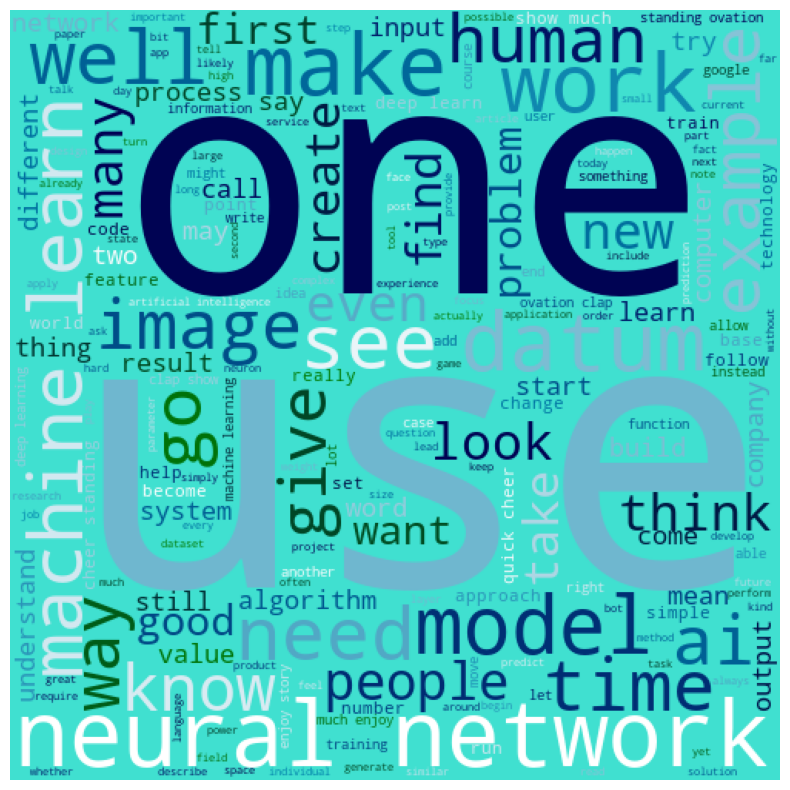

In [16]:
import wordcloud
from wordcloud import WordCloud

#combine all the articles
article_data = ""
for article in medium_articles.text:
    article_data = article_data+" "+article

#ploting the word cloud
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width = 500, height = 500, background_color='#40E0D0', colormap="ocean",  random_state=10).generate(article_data)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()



In [18]:
#tokenize articles
tokeize_article = medium_articles.text.apply(lambda x : x.split())
id2word = corpora.Dictionary(tokeize_article)

# Create Corpus
texts = tokeize_article

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


#printing 50 words from the text corpus
corpus_example = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]
corpus_example[0][:50]

[("'", 8),
 ('able', 1),
 ('abruptly', 1),
 ('acceptance', 1),
 ('access', 1),
 ('accident', 1),
 ('accord', 2),
 ('achieve', 2),
 ('adage', 1),
 ('advantage', 1),
 ('agenda', 1),
 ('ageold', 1),
 ('ago', 2),
 ('ai', 3),
 ('aim', 1),
 ('alive', 1),
 ('allow', 1),
 ('allrounder', 1),
 ('along', 1),
 ('also', 1),
 ('alternative', 1),
 ('amount', 1),
 ('analyze', 1),
 ('another', 5),
 ('answer', 1),
 ('anticipate', 1),
 ('anticlimax', 1),
 ('anyone', 1),
 ('anything', 2),
 ('app', 12),
 ('apply', 1),
 ('approach', 3),
 ('arcane', 2),
 ('area', 2),
 ('arise', 1),
 ('around', 3),
 ('asay', 1),
 ('ask', 1),
 ('aspect', 1),
 ('assumption', 1),
 ('attention', 1),
 ('automate', 1),
 ('automated', 1),
 ('available', 1),
 ('average', 1),
 ('away', 2),
 ('back', 3),
 ('baffle', 1),
 ('basic', 1),
 ('basically', 1)]

## Latent Dirichlet Allocation[LDA]:  

LDA algorithm is an unsupervised learning algorithm that works on a probabilistic statistical model to discover topics that the document contains automatically. <br> 
This algorithm works on certain assumptions. The assumption is that the document was generated by picking a set of topics and picking a set of words for each topic. In other words, we can say that the document is a probability distribution over the latent topics, and topics are probability distribution over the words.

Now let's understand the work methodology of LDA using Plate Diagram:
<br>


<img src="LDA.jpg" alt="LDA">

               


Here, $\alpha$ and $\beta$ are two hyperparameters that we have to initialise manually, and they symbolize per topic distribution($\alpha$) and per topic word distribution($\beta$), respectively. And **Z** is the topic for the **N**-th word in document **M**, and **W** is the specific word. We can only see W(specific words) in the documents because it is only an observable variable, and all others are latent.

$\theta$ is the matrix where rows are the documents; columns are topics, and $\theta(i,j)$ represents the probability of $ith$ document containing $jth$ topic. Similarly, $\phi$ is the matrix where rows are the topics; columns are words, and $\phi(i,j)$ represents the probability of $ith$ topic containing $jth$ word. According to the distribution of $\phi$; **K** individual words are generated for the topics.

With the help of this LDA, try to estimate the words that belong to each topic and find the topics in documents accordingly.

In [19]:
# build LDA model for 10 topic
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           per_word_topics=True,
                                           eta = 0.6)

In [20]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.010*"https" + 0.009*"sheet" + 0.009*"cheat" + 0.005*"numpy" + '
  '0.004*"python" + 0.003*"google" + 0.003*"machine" + 0.003*"library" + '
  '0.003*"matplotlib" + 0.003*"scipy"'),
 (1,
  '0.014*"action" + 0.009*"rcnn" + 0.008*"network" + 0.007*"policy" + '
  '0.006*"agent" + 0.006*"state" + 0.006*"reward" + 0.006*"environment" + '
  '0.006*"learn" + 0.006*"table"'),
 (2,
  '0.006*"machine" + 0.005*"course" + 0.005*"man" + 0.005*"review" + '
  '0.005*"woman" + 0.004*"average" + 0.004*"rating" + 0.004*"learn" + '
  '0.004*"attract" + 0.004*"week"'),
 (3,
  '0.005*"cell" + 0.003*"ion" + 0.003*"postsynaptic" + 0.003*"presynaptic" + '
  '0.003*"axon" + 0.002*"receptor" + 0.002*"synaptic" + 0.002*"terminal" + '
  '0.001*"metabolic" + 0.001*"ltp"'),
 (4,
  '0.023*"de" + 0.010*"la" + 0.009*"en" + 0.008*"que" + 0.005*"para" + '
  '0.004*"el" + 0.004*"l" + 0.004*"et" + 0.004*"como" + 0.004*"se"'),
 (5,
  '0.015*"learn" + 0.013*"deep" + 0.009*"machine" + 0.009*"learning" + '
  '0.005*"c

### Visualising Topics:

In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.280785  0.035579       1        1  46.577183
9     -0.172641 -0.046772       2        1  34.423264
5     -0.063658 -0.100783       3        1   5.952451
2      0.012452 -0.038519       4        1   4.622089
1     -0.053859  0.132596       5        1   4.207269
4      0.148579  0.022354       6        1   1.786449
0      0.081113 -0.010557       7        1   1.463860
6      0.113190 -0.000621       8        1   0.617649
3      0.109716  0.003711       9        1   0.221468
8      0.105893  0.003012      10        1   0.128318, topic_info=                        Term         Freq        Total Category  logprob  \
1029                 network  2730.000000  2730.000000  Default  30.0000   
335                    learn  2091.000000  2091.000000  Default  29.0000   
949                     deep   976.000000   976.000000  Default  28.0000   
360                  machine  1265.000000  1265.000000  Default  27.0000   
1030                  neural  1755.000000  1755.000000  Default  26.0000   
...                      ...          ...          ...      ...      ...   
4252         learning的圣经prml     0.044756     2.940019  Topic10  -9.1685   
4253               models那一张     0.044756     2.940018  Topic10  -9.1685   
4254             sampling的实现     0.044756     2.940019  Topic10  -9.1685   
4255            steyvers和tom     0.044756     2.940018  Topic10  -9.1685   
4259  一开始直接就下了blei的原始的那篇论文来看     0.044756     2.940018  Topic10  -9.1685   

      loglift  
1029  30.0000  
335   29.0000  
949   28.0000  
360   27.0000  
1030  26.0000  
...       ...  
4252   2.4735  
4253   2.4735  
4254   2.4735  
4255   2.4735  
4259   2.4735  

[607 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
0         1  0.294418                       '
0         2  0.681203                       '
0         6  0.017319                       '
0         7  0.002886                       '
2014      1  0.028688                       a
...     ...       ...                     ...
4296      2  0.340134       我觉得对于我们这些门外汉程序员来说
4301      1  0.340134     正好看到science上这篇topic
4301      2  0.340134     正好看到science上这篇topic
4304      1  0.340134  没有整块业余时间的我是觉得还是容易退缩放弃的
4304      2  0.340134  没有整块业余时间的我是觉得还是容易退缩放弃的

[1824 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 6, 3, 2, 5, 1, 7, 4, 9])

In [22]:
# Compute Perplexity
print('\nPerplexity : ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity :  -7.818278226611068

Coherence Score:  0.4306245111374106


In [90]:
def compute_coherence_values(dictionary,corpus,texts,limit,start=2,steps=1):
    coherence_value = []
    model_list = []
    for num_topics in range(start,limit,steps):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True,
                                          )
        model_list.append(model)
        coherencemodel1 = CoherenceModel(model= model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_value.append(coherencemodel1.get_coherence())
    return model_list,coherence_value

In [93]:
# model_list,coherence_value = compute_coherence_values(dictionary=id2word,corpus=corpus,texts=tokeize_article,limit=15,start=2,steps=1)
# coherence_value

[0.353433037844489,
 0.36543582931067453,
 0.37570110541453566,
 0.36706153204569614,
 0.3486114843542045,
 0.3639933954391767,
 0.42057471280482234,
 0.4129485150527118,
 0.42657801848640686,
 0.3938231269142085,
 0.42741014923071835,
 0.4081478863959885,
 0.43063585346932054]

### Tuning hyperparameters:

We can try out different number of topics, different values of alpha and beta(eta) to increse the conharence score. High conherence score is good for our model.

In [30]:
def calculate_coherence_score(n, alpha, beta):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

#list containing various hyperparameters
no_of_topics = [2,5,7,10,12,14]
alpha_list = ['symmetric',0.3,0.5,0.7]
beta_list = ['auto',0.3,0.5,0.7]


for n in no_of_topics:
    for alpha in alpha_list:
        for beta in beta_list:
            coherence_score = calculate_coherence_score(n, alpha, beta)
            print(f"n : {n} ; alpha : {alpha} ; beta : {beta} ; Score : {coherence_score}")

n : 2 ; alpha : symmetric ; beta : auto ; Score : 0.353433037844489
n : 2 ; alpha : symmetric ; beta : 0.3 ; Score : 0.353433037844489
n : 2 ; alpha : symmetric ; beta : 0.5 ; Score : 0.353433037844489
n : 2 ; alpha : symmetric ; beta : 0.7 ; Score : 0.36374370071604456
n : 2 ; alpha : 0.3 ; beta : auto ; Score : 0.353433037844489
n : 2 ; alpha : 0.3 ; beta : 0.3 ; Score : 0.353433037844489
n : 2 ; alpha : 0.3 ; beta : 0.5 ; Score : 0.353433037844489
n : 2 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.36374370071604456
n : 2 ; alpha : 0.5 ; beta : auto ; Score : 0.353433037844489
n : 2 ; alpha : 0.5 ; beta : 0.3 ; Score : 0.353433037844489
n : 2 ; alpha : 0.5 ; beta : 0.5 ; Score : 0.353433037844489
n : 2 ; alpha : 0.5 ; beta : 0.7 ; Score : 0.36374370071604456
n : 2 ; alpha : 0.7 ; beta : auto ; Score : 0.353433037844489
n : 2 ; alpha : 0.7 ; beta : 0.3 ; Score : 0.353433037844489
n : 2 ; alpha : 0.7 ; beta : 0.5 ; Score : 0.353433037844489
n : 2 ; alpha : 0.7 ; beta : 0.7 ; Score : 0.363743

### Highest Coherence Score : 0.58 with n=12(topics) alpha=0.8 beta=0.7

In [95]:
n = 12
alpha = 0.8
beta = 0.7
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print('\nPerplexity : ', lda_model.log_perplexity(corpus))


Coherence Score:  0.5888035811535954

Perplexity :  -7.859013887653711


### Final LDA Model

In [98]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.309067  0.032747       1        1  48.205702
9      0.203495 -0.077925       2        1  37.350166
1      0.038041  0.114299       3        1   3.513495
2     -0.006866 -0.018271       4        1   3.512345
10    -0.029205 -0.043429       5        1   2.686003
5     -0.062588 -0.011798       6        1   1.307226
4     -0.101936  0.010856       7        1   1.280744
0     -0.060994 -0.009286       8        1   0.915559
8     -0.072397 -0.000124       9        1   0.413997
6     -0.072377 -0.001797      10        1   0.351194
11    -0.074689  0.002706      11        1   0.348337
3     -0.069551  0.002023      12        1   0.115230, topic_info=                               Term         Freq       Total Category  \
335                           learn  2199.000000  2199.00000  Default   
360                         machine  1305.000000  1305.00000  Default   
1029                        network  2719.000000  2719.00000  Default   
1030                         neural  1741.000000  1741.00000  Default   
709                          course   326.000000   326.00000  Default   
...                             ...          ...         ...      ...   
4272  但是看了个开头就被dirichlet分布和几个数学公式打倒     0.037665     3.21182  Topic12   
4273        但是这样先看看也比较容易对于这些数学问题的兴趣     0.037665     3.21182  Topic12   
4274                    先把这些搞定就能干活了     0.037665     3.21182  Topic12   
4276             再去prml里看了一遍graphic     0.037665     3.21182  Topic12   
4278                  再次回顾了一下基本数学知识     0.037665     3.21182  Topic12   

      logprob  loglift  
335   30.0000  30.0000  
360   29.0000  29.0000  
1029  28.0000  28.0000  
1030  27.0000  27.0000  
709   26.0000  26.0000  
...       ...      ...  
4272  -9.2334   2.3201  
4273  -9.2334   2.3201  
4274  -9.2334   2.3201  
4276  -9.2334   2.3201  
4278  -9.2334   2.3201  

[648 rows x 6 columns], token_table=      Topic      Freq                          Term
term                                               
5492      1  0.196979                     acquihire
5492      2  0.196979                     acquihire
5492      6  0.393958                     acquihire
899       1  0.093395                        action
899       2  0.332072                        action
...     ...       ...                           ...
4302      2  0.311350                          正态分布
4309      1  0.311350                 看实际应用的实例比较有感觉
4309      2  0.311350                 看实际应用的实例比较有感觉
4326      1  0.311350  除了集体智慧编程这本书之外基本没怎么看过机器学习的人来说
4326      2  0.311350  除了集体智慧编程这本书之外基本没怎么看过机器学习的人来说

[1889 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 2, 3, 11, 6, 5, 1, 9, 7, 12, 4])

In [35]:
import wordcloud
from wordcloud import WordCloud,STOPWORDS
import matplotlib.colors as mcolors



In [101]:
cols = [color for name,color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                 background_color = 'white',
                 width=2500,
                 height=2800,
                 max_words=20,
                 colormap='table',
                 color_func = lambda *args,**kwargs: cols[i],
                 prefer_horizontal = 1.0)

topics = sorted(lda_model.show_topics(formatted=False), key=lambda x: x[0])
topics

[(1,
  [('action', 0.014020609),
   ('rcnn', 0.009069991),
   ('table', 0.0064291516),
   ('agent', 0.006352163),
   ('environment', 0.006105223),
   ('state', 0.0060441503),
   ('reward', 0.00595524),
   ('policy', 0.005707964),
   ('cnn', 0.004397644),
   ('region', 0.0043793423)]),
 (2,
  [('course', 0.014305543),
   ('learn', 0.013115171),
   ('machine', 0.012332359),
   ('review', 0.0056738807),
   ('week', 0.0053373855),
   ('rating', 0.0047980533),
   ('hour', 0.004433998),
   ('python', 0.0043613967),
   ('datum', 0.0042980784),
   ('average', 0.003998246)]),
 (3,
  [('。', 0.00021871933),
   ('不然', 9.7717915e-05),
   ('正好看到science上这篇topic', 9.7717915e-05),
   ('觉得对于lda想解决的问题和方法了解了更清楚了。之后从search', 9.7717915e-05),
   ('然后了解了下贝叶斯学派那种采用共轭先验来建模的方式。于是再次尝试回头去看blei的那篇论文', 9.7717915e-05),
   ('没有整块业余时间的我是觉得还是容易退缩放弃的', 9.7717915e-05),
   ('记录一下', 9.7717915e-05),
   ('比如blei的论文在没有任何相关知识的情况下一开始读了好几次', 9.7717915e-05),
   ('正态分布', 9.7717915e-05),
   ('看来不能把大部分时间花在prml上', 9.7717915e-05)]),
 (

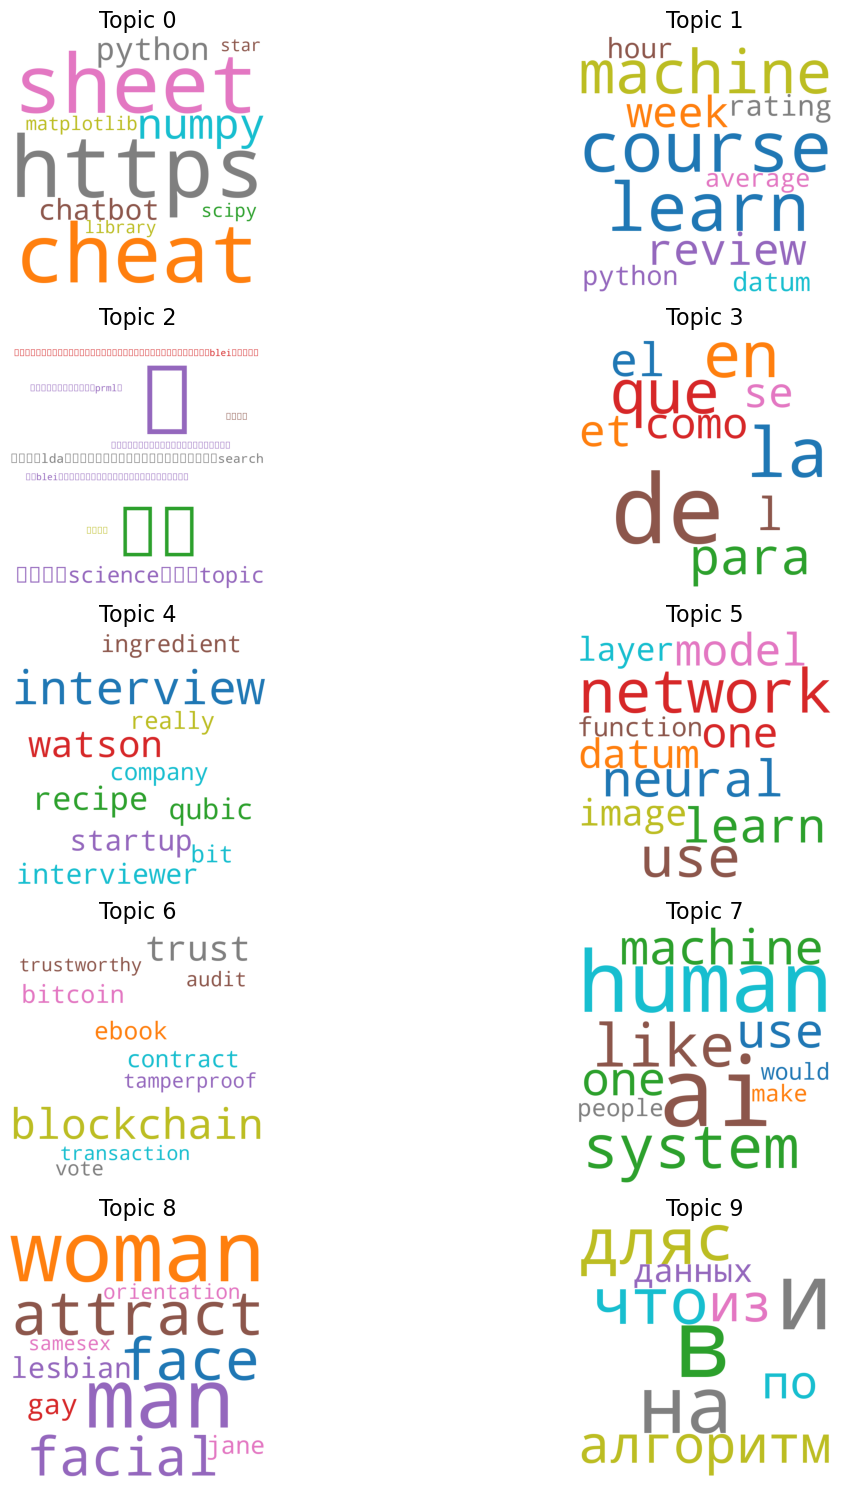

In [97]:

# Get a list of colors for the word clouds
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Initialize WordCloud object
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=800,
                  height=800,
                  max_words=20,
                  colormap='tab10',  # Updated to 'tab10' colormap
                  prefer_horizontal=1.0)

# Get the topics from the lda model
topics = sorted(lda_model.show_topics(formatted=False), key=lambda x: x[0])

fig, axes = plt.subplots(5, 2, figsize=(15, 15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i < len(topics):  # Ensure we don't exceed the number of topics
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        ax.imshow(cloud)
        ax.set_title('Topic {}'.format(i), fontdict=dict(size=16))
        ax.axis('off')
    else:
        ax.axis('off')  # Hide any extra empty subplots

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

